<a href="https://colab.research.google.com/github/sahilpatil6305/Exploratory-Project/blob/main/LINK_PREDICTION.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations
from sklearn.model_selection import train_test_split
import random
from sklearn.metrics import (
    auc,roc_auc_score, precision_score, recall_score,
    accuracy_score, confusion_matrix, roc_curve
)


"""
### Les Misérables Dataset  

**Les Misérables** is a classic novel by **Victor Hugo**, published in **1862**, depicting themes of justice, redemption, and revolution in 19th-century France. The **Les Misérables dataset** is a **social network graph** representing **character co-occurrences** within the novel.  

- **Nodes (Vertices):** Each node represents a **character** in the novel.  
- **Edges (Links):** Each edge represents a **co-occurrence** of two characters in the same chapter.  
- **Edge Weights:** The **weight** of an edge indicates the **frequency** of co-occurrences between two characters.  

This dataset is widely used in **social network analysis, link prediction, and community detection**.  

The **Les Misérables dataset**, as provided by **NetworkX**, contains:  

- **Nodes (Characters):** 77  
- **Edges (Co-occurrences):** 254  

This means the graph represents **77 characters** from the novel, and there are **254 connections (edges)** between them based on their co-occurrences in the same chapter.  
"""


In [ ]:
# Load Les Miserables Graph (from NetworkX)
G_les_miserables = nx.les_miserables_graph()
G_les_miserables = G_les_miserables.to_undirected()


In [ ]:
print("Number of Nodes:", G_les_miserables.number_of_nodes())
print("Number of Edges:", G_les_miserables.number_of_edges())


Number of Nodes: 77
Number of Edges: 254


In [ ]:

# Plot original graph
plt.figure(figsize=(6, 6))
nx.draw(G, with_labels=True, node_color='lightblue', edge_color='gray')
plt.title("Original Graph")
plt.show()


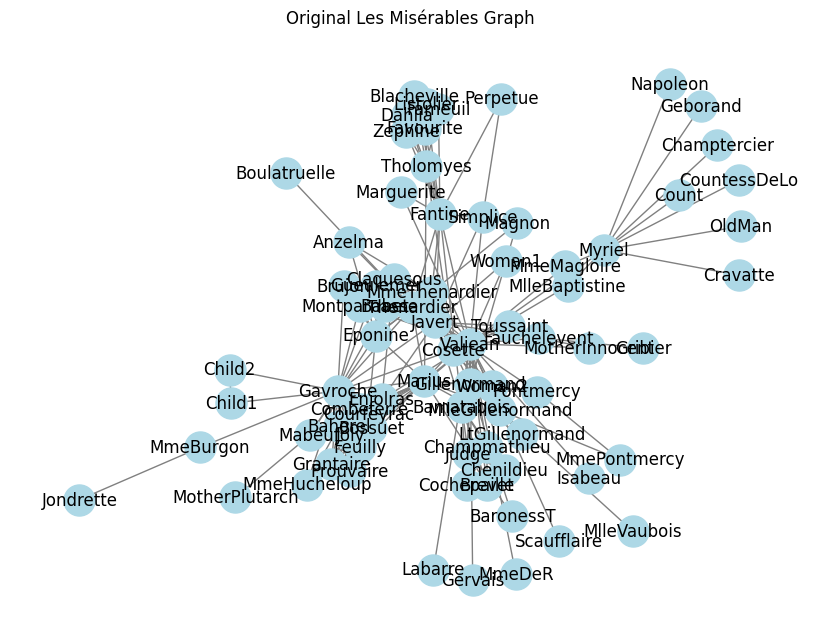

In [ ]:
visualize_graph(G_les_miserables, "Original Les Misérables Graph")


In [ ]:
def remove_edges(graph, percentage=0.2):
    num_edges_to_remove = int(len(graph.edges) * percentage)
    edges_to_remove = random.sample(list(graph.edges), num_edges_to_remove)
    graph_modified = graph.copy()
    graph_modified.remove_edges_from(edges_to_remove)
    return graph_modified, edges_to_remove

G_edge_removed, removed_edges = remove_edges(G_les_miserables, 0.2)


In [ ]:
print("No of Nodes")
print("For Original graph:", G_les_miserables.number_of_nodes() ,"   ","For Edge removed graph:", G_edge_removed.number_of_nodes())
print()
print("No of Edges")
print("For Original graph:", G_les_miserables.number_of_edges() ,"   ","For Edge removed graph:", G_edge_removed.number_of_edges())


No of Nodes
For Original graph: 77     For Edge removed graph: 77

No of Edges
For Original graph: 254     For Edge removed graph: 204


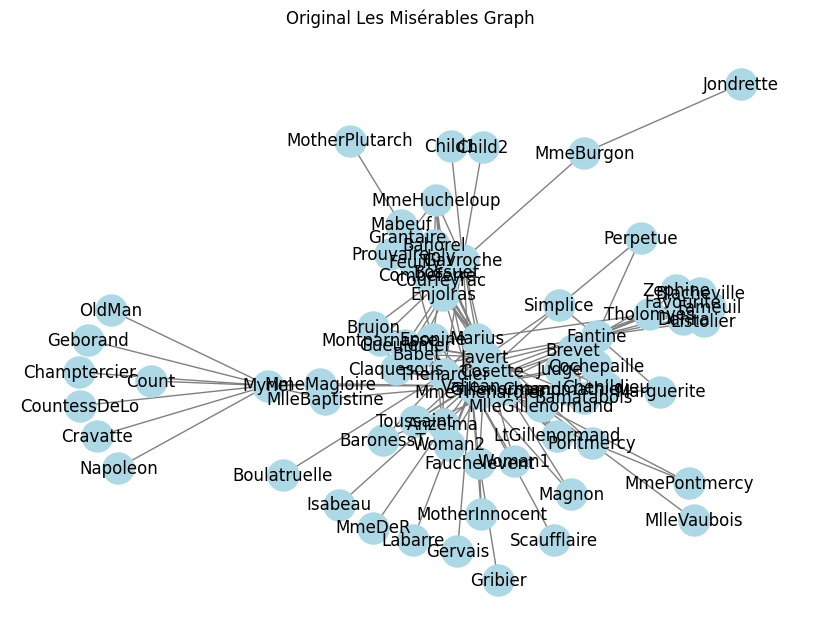

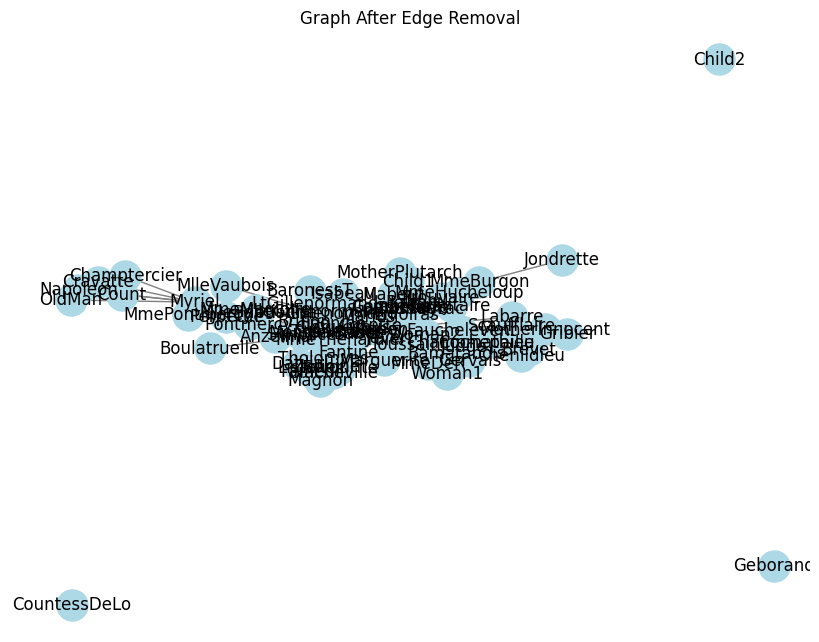

In [ ]:
visualize_graph(G_les_miserables, "Original Les Misérables Graph")
print()
visualize_graph(G_edge_removed, "Graph After Edge Removal")


In [ ]:
# Function to compute link prediction scores
def link_prediction_scores(graph, test_edges):
import networkx as nx
import numpy as np

def compute_scores(graph, test_set, metric):
    scores = []
    for u, v in test_set:
        if u not in graph or v not in graph:
            scores.append(0)  # Assign a default score if nodes are missing
            continue

        if metric == "adamic_adar":
            score = sum(1 / np.log(graph.degree(w)) for w in nx.common_neighbors(graph, u, v) if graph.degree(w) > 1)
        elif metric == "jaccard":
            neighbors_u = set(graph.neighbors(u))
            neighbors_v = set(graph.neighbors(v))
            score = len(neighbors_u & neighbors_v) / len(neighbors_u | neighbors_v) if len(neighbors_u | neighbors_v) > 0 else 0
        elif metric == "preferential_attachment":
            score = graph.degree(u) * graph.degree(v)
        elif metric == "common_neighbors":
            score = len(list(nx.common_neighbors(graph, u, v)))
        elif metric == "salton_index":
            neighbors_u = set(graph.neighbors(u))
            neighbors_v = set(graph.neighbors(v))
            denominator = np.sqrt(len(neighbors_u) * len(neighbors_v))
            score = len(neighbors_u & neighbors_v) / denominator if denominator > 0 else 0
        elif metric == "hub_promoted_index":
            neighbors_u = set(graph.neighbors(u))
            neighbors_v = set(graph.neighbors(v))
            min_degree = min(len(neighbors_u), len(neighbors_v))
            score = len(neighbors_u & neighbors_v) / min_degree if min_degree > 0 else 0
        else:
            raise ValueError("Unknown metric")

        scores.append(score)

    return np.array(scores)


In [ ]:
def evaluate_model(graph, removed_edges):
    scores, y_true, predictions = link_prediction_scores(graph, removed_edges)

    metrics = {}

    for method, y_pred in scores.items():
        auc = roc_auc_score(y_true, y_pred)
        precision = precision_score(y_true, [1 if score >= 0.5 else 0 for score in y_pred])
        recall = recall_score(y_true, [1 if score >= 0.5 else 0 for score in y_pred])
        accuracy = accuracy_score(y_true, [1 if score >= 0.5 else 0 for score in y_pred])
        conf_matrix = confusion_matrix(y_true, [1 if score >= 0.5 else 0 for score in y_pred])

        metrics[method] = {
            "AUC-ROC": auc,
            "Precision": precision,
            "Recall": recall,
            "Accuracy": accuracy,
            "Confusion Matrix": conf_matrix
        }

        print(f"{method} Metrics:")
        print(f"AUC-ROC: {auc:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, Accuracy: {accuracy:.4f}")
        print("Confusion Matrix:\n", conf_matrix)
        print("-" * 50)

    return metrics, scores, y_true, predictions

metrics, scores, y_true, predictions = evaluate_model(G_edge_removed, removed_edges)


Jaccard Metrics:
AUC-ROC: 0.8524, Precision: 0.8947, Recall: 0.3400, Accuracy: 0.6500
Confusion Matrix:
 [[48  2]
 [33 17]]
--------------------------------------------------
Adamic-Adar Metrics:
AUC-ROC: 0.9102, Precision: 0.8750, Recall: 0.8400, Accuracy: 0.8600
Confusion Matrix:
 [[44  6]
 [ 8 42]]
--------------------------------------------------
Preferential Attachment Metrics:
AUC-ROC: 0.8188, Precision: 0.5055, Recall: 0.9200, Accuracy: 0.5100
Confusion Matrix:
 [[ 5 45]
 [ 4 46]]
--------------------------------------------------


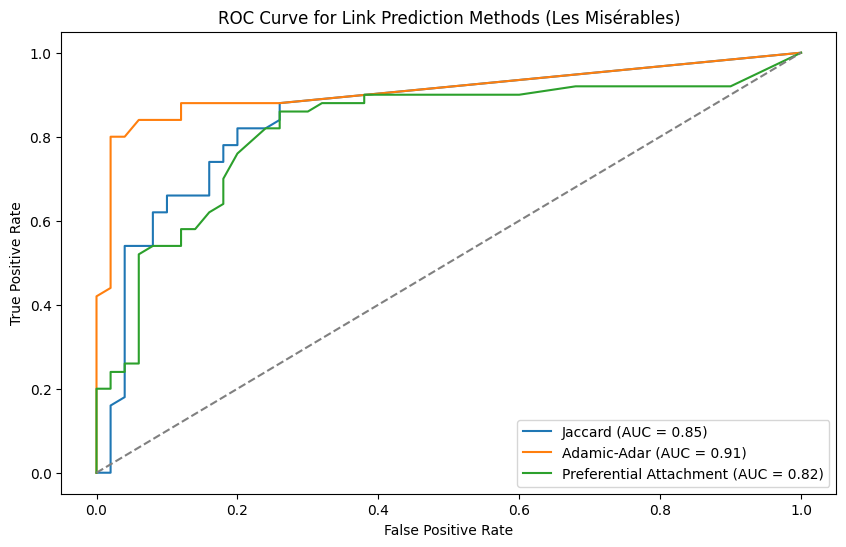

In [ ]:
plt.figure(figsize=(10, 6))

for method in scores.keys():
    fpr, tpr, _ = roc_curve(y_true, scores[method])
    plt.plot(fpr, tpr, label=f'{method} (AUC = {metrics[method]["AUC-ROC"]:.2f})')

plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Link Prediction Methods (Les Misérables)')
plt.legend()
plt.show()


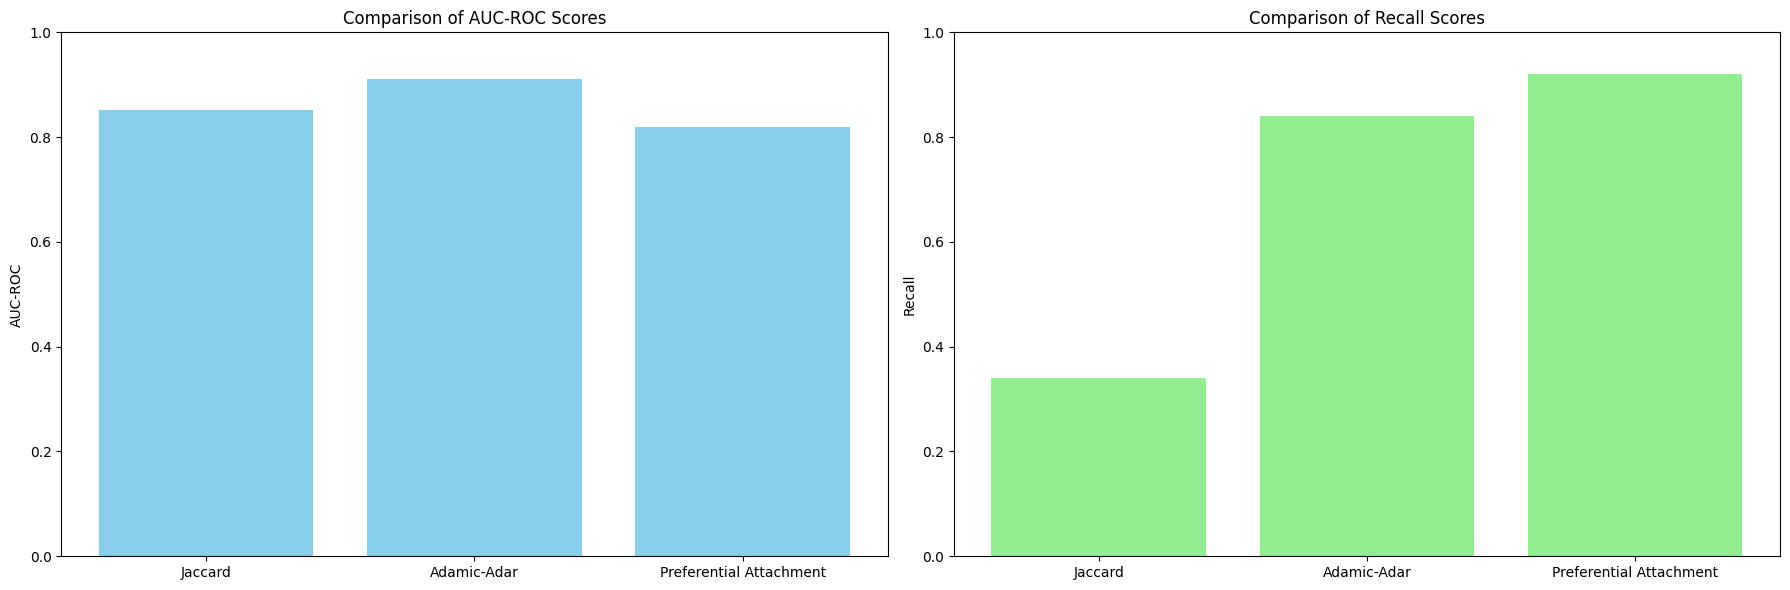

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Bar plot for AUC-ROC
axes[0].bar(metrics.keys(), [m["AUC-ROC"] for m in metrics.values()], color='skyblue')
axes[0].set_title('Comparison of AUC-ROC Scores')
axes[0].set_ylabel('AUC-ROC')
axes[0].set_ylim([0, 1])

# Bar plot for Recall
axes[1].bar(metrics.keys(), [m["Recall"] for m in metrics.values()], color='lightgreen')
axes[1].set_title('Comparison of Recall Scores')
axes[1].set_ylabel('Recall')
axes[1].set_ylim([0, 1])

plt.tight_layout()
plt.show()


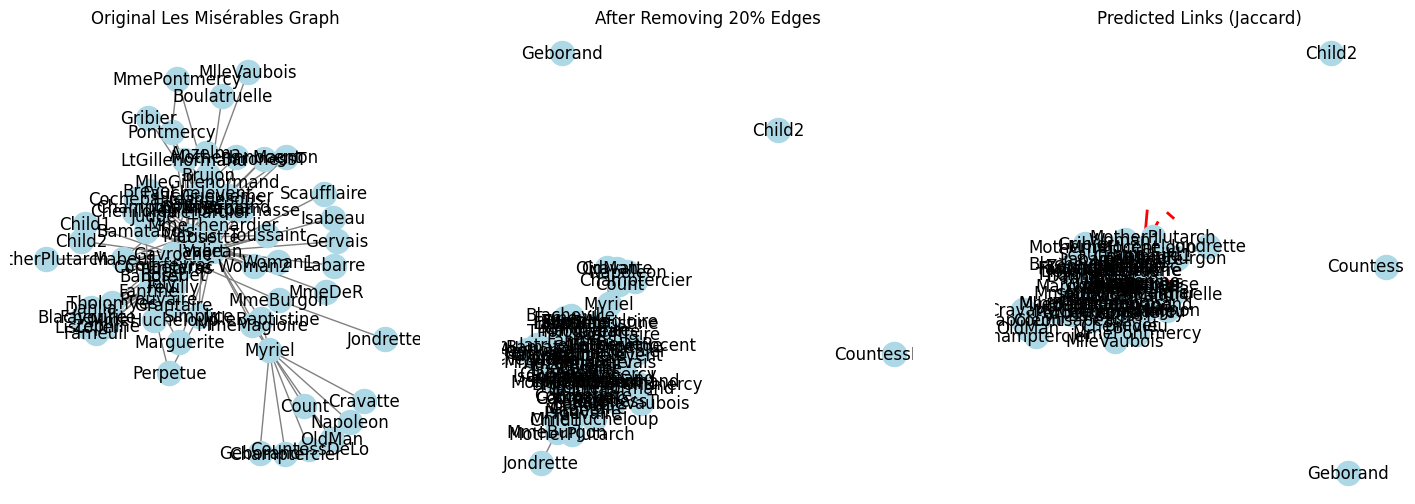

In [ ]:
# Select top predicted edges for Jaccard
top_predicted_edges = sorted(predictions["Jaccard"], key=lambda x: x[2], reverse=True)[:10]

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Original Graph
plt.subplot(1, 3, 1)
nx.draw(G_les_miserables, with_labels=True, node_color='lightblue', edge_color='gray')
plt.title("Original Les Misérables Graph")

# Graph After Removing 20% Edges
plt.subplot(1, 3, 2)
nx.draw(G_edge_removed, with_labels=True, node_color='lightblue', edge_color='gray')
plt.title("After Removing 20% Edges")

# Graph With Predicted Links (Jaccard)
plt.subplot(1, 3, 3)
nx.draw(G_edge_removed, with_labels=True, node_color='lightblue', edge_color='gray')
nx.draw_networkx_edges(G_edge_removed, pos=nx.spring_layout(G_edge_removed),
                       edgelist=[(u, v) for u, v, _ in top_predicted_edges], edge_color='red', width=2)
plt.title("Predicted Links (Jaccard)")

plt.show()


"""
### Karate Club Graph  

The **Karate Club Graph** is a well-known **social network dataset** collected by **Wayne Zachary** in **1977**. It represents the **friendship network** of 34 members of a **karate club** at a U.S. university.  

- **Nodes (Vertices):**  
  - Each node represents a **club member**.  
- **Edges (Links):**  
  - An edge exists between two members if they **interacted** outside the club.  

This dataset is widely used in **community detection, graph clustering, and social network analysis**.  

The **Karate Club dataset**, as provided by **NetworkX**, contains:  

- **Nodes:** 34 (Club members)  
- **Edges:** 78 (Friendship connections)  

This means the graph consists of **34 nodes** and **78 edges**, where edges indicate friendship ties between club members.  

Additionally, due to a **dispute** between the **club president** and the **instructor**, the club **split into two factions**, making it an ideal dataset for testing **community detection algorithms**.  
"""


In [ ]:
# Load Karate Club Graph
G_karate = nx.karate_club_graph()
G_karate = G_karate.to_undirected()


In [ ]:
print("Number of Nodes:", G_karate.number_of_nodes())
print("Number of Edges:", G_karate.number_of_edges())


Number of Nodes: 34
Number of Edges: 78


In [ ]:
# Function to visualize a graph
def visualize_graph(graph, title):
    plt.figure(figsize=(8, 6))
    nx.draw(graph, with_labels=True, node_color='lightblue', edge_color='gray', node_size=500)
    plt.title(title)
    plt.show()


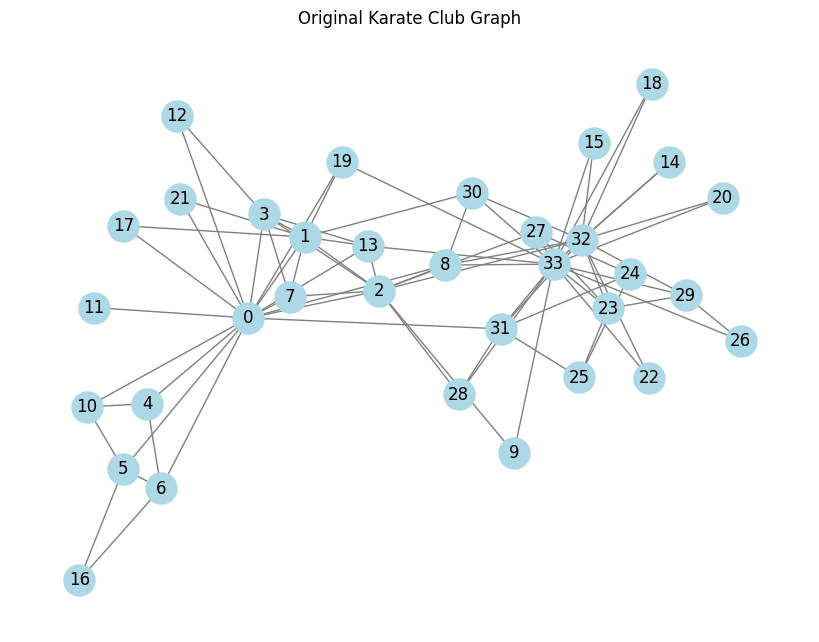

In [ ]:
visualize_graph(G_karate, "Original Karate Club Graph")


In [ ]:
print("No of Nodes")
print("For Original graph:", G_karate.number_of_nodes() ,"   ","For Edge removed graph:", G_edge_removed.number_of_nodes())
print()
print("No of Edges")
print("For Original graph:", G_karate.number_of_edges() ,"   ","For Edge removed graph:", G_edge_removed.number_of_edges())


No of Nodes
For Original graph: 34     For Edge removed graph: 77

No of Edges
For Original graph: 78     For Edge removed graph: 204


In [ ]:
def remove_edges(graph, proportion=0.20):
    edges_list = list(graph.edges())
    num_edges_to_remove = int(proportion * len(edges_list))
    edges_to_remove = random.sample(edges_list, num_edges_to_remove)

    # Create a copy and remove edges
    graph_train = graph.copy()
    graph_train.remove_edges_from(edges_to_remove)

    return graph_train, edges_to_remove

G_edge_removed, removed_edges = remove_edges(G_edge_removed, 0.2)


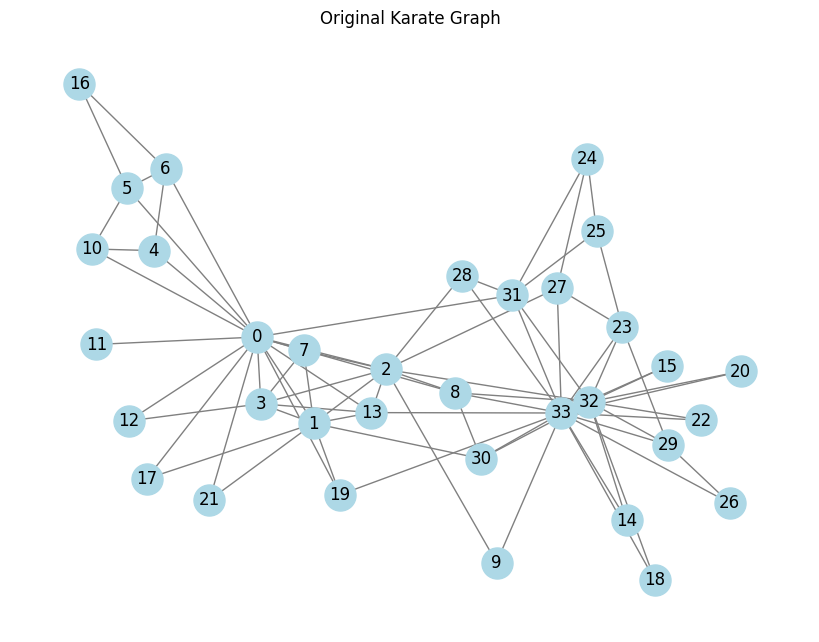

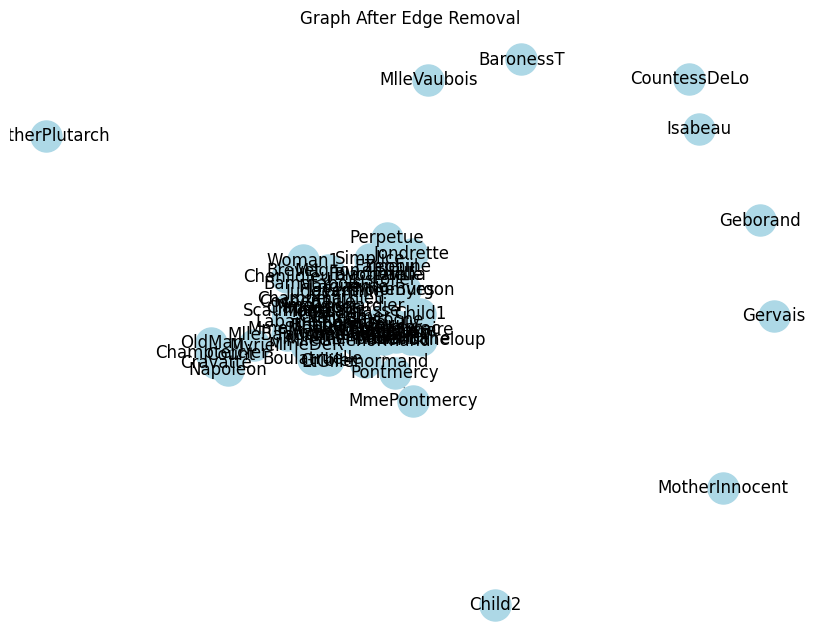

In [ ]:
visualize_graph(G_karate, "Original Karate Graph")
print()
visualize_graph(G_edge_removed, "Graph After Edge Removal")


In [ ]:
def link_prediction_scores(graph, test_edges):
    scores = {"Jaccard": [], "Adamic-Adar": [], "Preferential Attachment": []}
    y_true = []
    predictions = {"Jaccard": [], "Adamic-Adar": [], "Preferential Attachment": []}

    # Generate negative samples (random non-existing edges)
    non_edges = list(nx.non_edges(graph))
    test_non_edges = random.sample(non_edges, len(test_edges))

    for edge, is_positive in zip(test_edges + test_non_edges, [1] * len(test_edges) + [0] * len(test_non_edges)):
        node1, node2 = edge
        scores["Jaccard"].append(list(nx.jaccard_coefficient(graph, [(node1, node2)]))[0][2])
        scores["Adamic-Adar"].append(list(nx.adamic_adar_index(graph, [(node1, node2)]))[0][2])
        scores["Preferential Attachment"].append(list(nx.preferential_attachment(graph, [(node1, node2)]))[0][2])
        y_true.append(is_positive)

        # Store top predicted links
        if is_positive == 0:
            predictions["Jaccard"].append((node1, node2, scores["Jaccard"][-1]))
            predictions["Adamic-Adar"].append((node1, node2, scores["Adamic-Adar"][-1]))
            predictions["Preferential Attachment"].append((node1, node2, scores["Preferential Attachment"][-1]))

    return scores, y_true, predictions


In [ ]:
def evaluate_model(graph, removed_edges):
    scores, y_true, predictions = link_prediction_scores(graph, removed_edges)

    metrics = {}

    for method, y_pred in scores.items():
        auc = roc_auc_score(y_true, y_pred)
        precision = precision_score(y_true, [1 if score >= 0.5 else 0 for score in y_pred])
        recall = recall_score(y_true, [1 if score >= 0.5 else 0 for score in y_pred])
        accuracy = accuracy_score(y_true, [1 if score >= 0.5 else 0 for score in y_pred])
        conf_matrix = confusion_matrix(y_true, [1 if score >= 0.5 else 0 for score in y_pred])

        metrics[method] = {
            "AUC-ROC": auc,
            "Precision": precision,
            "Recall": recall,
            "Accuracy": accuracy,
            "Confusion Matrix": conf_matrix
        }

        print(f"\n🔹 {method} Evaluation:")
        print(f"AUC-ROC: {auc:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Confusion Matrix:\n{conf_matrix}")

    return metrics, scores, y_true


In [ ]:
metrics, scores, y_true = evaluate_model(G_edge_removed, removed_edges)



🔹 Jaccard Evaluation:
AUC-ROC: 0.7808
Precision: 0.7500
Recall: 0.0938
Accuracy: 0.5312
Confusion Matrix:
[[31  1]
 [29  3]]

🔹 Adamic-Adar Evaluation:
AUC-ROC: 0.8081
Precision: 0.8750
Recall: 0.6562
Accuracy: 0.7812
Confusion Matrix:
[[29  3]
 [11 21]]

🔹 Preferential Attachment Evaluation:
AUC-ROC: 0.7773
Precision: 0.5577
Recall: 0.9062
Accuracy: 0.5938
Confusion Matrix:
[[ 9 23]
 [ 3 29]]


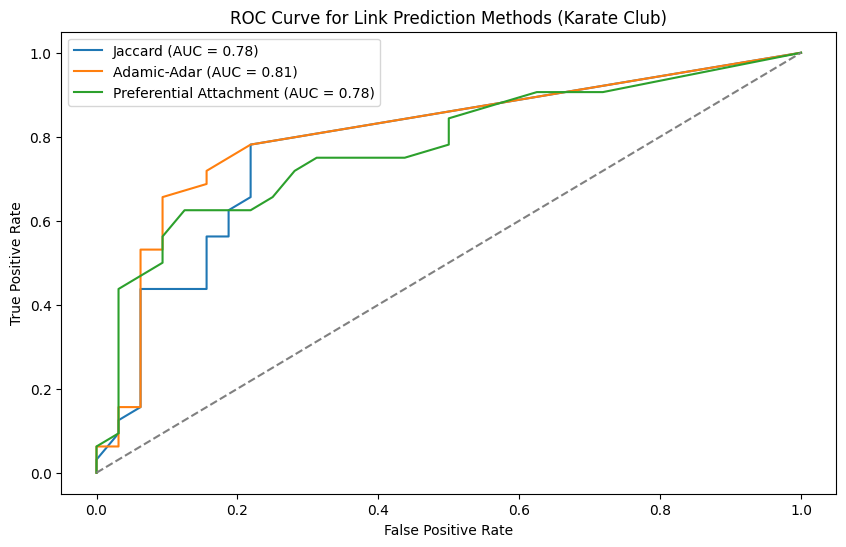

In [ ]:
def plot_roc_curve(scores, y_true):
    plt.figure(figsize=(10, 6))
    for method, y_pred in scores.items():
        fpr, tpr, _ = roc_curve(y_true, y_pred)
        plt.plot(fpr, tpr, label=f'{method} (AUC = {roc_auc_score(y_true, y_pred):.2f})')

    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for Link Prediction Methods (Karate Club)')
    plt.legend()
    plt.show()

plot_roc_curve(scores, y_true)


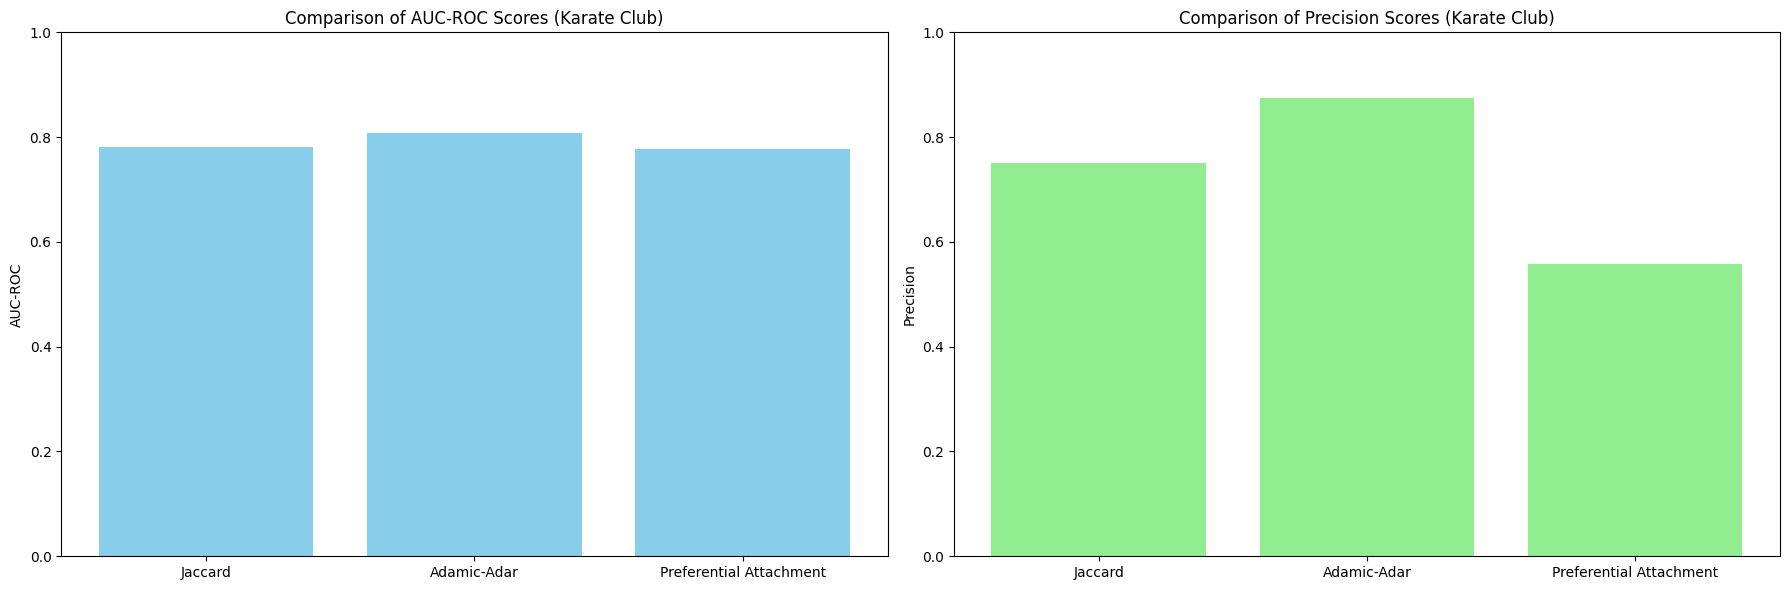

In [ ]:
def plot_metrics(metrics):
    methods = list(metrics.keys())
    aucs = [metrics[m]["AUC-ROC"] for m in methods]
    precisions = [metrics[m]["Precision"] for m in methods]

    fig, axes = plt.subplots(1, 2, figsize=(18, 6))

    axes[0].bar(methods, aucs, color='skyblue')
    axes[0].set_title('Comparison of AUC-ROC Scores (Karate Club)')
    axes[0].set_ylabel('AUC-ROC')
    axes[0].set_ylim([0, 1])

    axes[1].bar(methods, precisions, color='lightgreen')
    axes[1].set_title('Comparison of Precision Scores (Karate Club)')
    axes[1].set_ylabel('Precision')
    axes[1].set_ylim([0, 1])

    plt.tight_layout()
    plt.show()

plot_metrics(metrics)


"""
### Davis Southern Women Graph  

The **Davis Southern Women Graph** is a classic **bipartite social network dataset** collected by **Allison Davis, Burleigh Gardner, and Mary Gardner** in **1941**. It represents the **attendance of 18 Southern women** at **14 social events** in a town in the southern United States.  

- **Nodes (Vertices):**  
  - One set of nodes represents **18 women**.  
  - The other set represents **14 events**.  
- **Edges (Links):**  
  - An edge exists between a **woman** and an **event** if she attended that event.  

This dataset is widely used in **social network analysis, community detection, and bipartite graph modeling**.  

The **Davis Southern Women dataset**, as provided by **NetworkX**, contains:  

- **Nodes:** 32 (18 women + 14 events)  
- **Edges:** 89 (Connections between women and the events they attended)  

This means the graph consists of **32 nodes** and **89 edges**, where edges indicate the participation of a woman in a specific event.  
"""


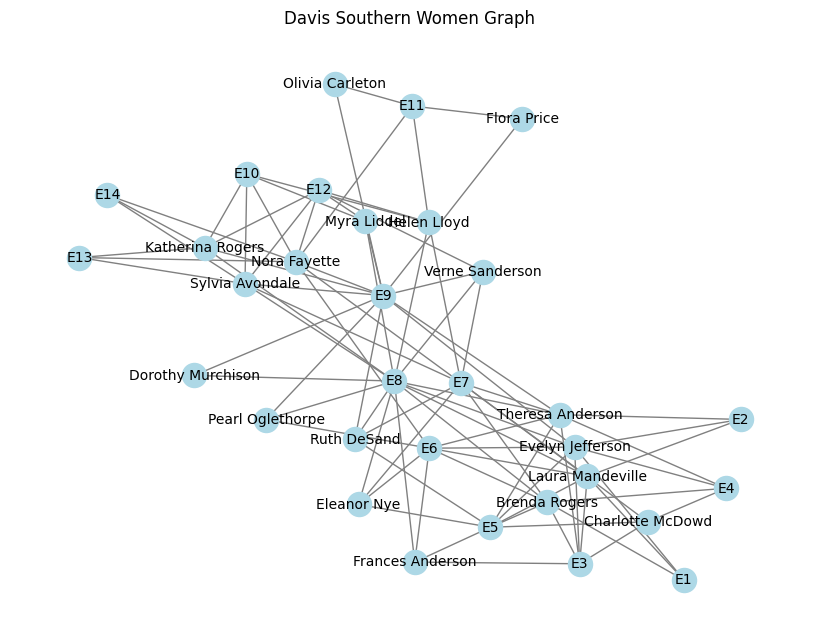

In [ ]:

# Load the Davis Southern Women Graph
G = nx.davis_southern_women_graph()

# Plot original graph
plt.figure(figsize=(8, 6))
nx.draw(G, with_labels=True, node_color='lightblue', edge_color='gray', font_size=10)
plt.title("Davis Southern Women Graph")
plt.show()




In [ ]:
# List all nodes in the graph
all_nodes = list(G.nodes())
print(f"All nodes in the graph: {all_nodes}")

# List all edges in the graph
all_edges = list(G.edges())
print(f"All edges in the original graph: {all_edges}")


All nodes in the graph: ['Evelyn Jefferson', 'Laura Mandeville', 'Theresa Anderson', 'Brenda Rogers', 'Charlotte McDowd', 'Frances Anderson', 'Eleanor Nye', 'Pearl Oglethorpe', 'Ruth DeSand', 'Verne Sanderson', 'Myra Liddel', 'Katherina Rogers', 'Sylvia Avondale', 'Nora Fayette', 'Helen Lloyd', 'Dorothy Murchison', 'Olivia Carleton', 'Flora Price', 'E1', 'E2', 'E3', 'E4', 'E5', 'E6', 'E7', 'E8', 'E9', 'E10', 'E11', 'E12', 'E13', 'E14']
All edges in the original graph: [('Evelyn Jefferson', 'E1'), ('Evelyn Jefferson', 'E2'), ('Evelyn Jefferson', 'E3'), ('Evelyn Jefferson', 'E4'), ('Evelyn Jefferson', 'E5'), ('Evelyn Jefferson', 'E6'), ('Evelyn Jefferson', 'E8'), ('Evelyn Jefferson', 'E9'), ('Laura Mandeville', 'E1'), ('Laura Mandeville', 'E2'), ('Laura Mandeville', 'E3'), ('Laura Mandeville', 'E5'), ('Laura Mandeville', 'E6'), ('Laura Mandeville', 'E7'), ('Laura Mandeville', 'E8'), ('Theresa Anderson', 'E2'), ('Theresa Anderson', 'E3'), ('Theresa Anderson', 'E4'), ('Theresa Anderson', '

Edges selected for removal: [('Theresa Anderson', 'E7'), ('Theresa Anderson', 'E8'), ('Theresa Anderson', 'E9'), ('Brenda Rogers', 'E1'), ('Brenda Rogers', 'E3'), ('Brenda Rogers', 'E4'), ('Brenda Rogers', 'E5'), ('Brenda Rogers', 'E6'), ('Brenda Rogers', 'E7'), ('Brenda Rogers', 'E8'), ('Charlotte McDowd', 'E3'), ('Charlotte McDowd', 'E4'), ('Charlotte McDowd', 'E5'), ('Charlotte McDowd', 'E7'), ('Frances Anderson', 'E3'), ('Frances Anderson', 'E5'), ('Frances Anderson', 'E6'), ('Eleanor Nye', 'E8'), ('Charlotte McDowd', 'E7'), ('Frances Anderson', 'E3'), ('Frances Anderson', 'E5'), ('Frances Anderson', 'E6'), ('Frances Anderson', 'E8'), ('Eleanor Nye', 'E5'), ('Eleanor Nye', 'E6'), ('Eleanor Nye', 'E7'), ('Eleanor Nye', 'E8'), ('Pearl Oglethorpe', 'E6'), ('Pearl Oglethorpe', 'E8'), ('Pearl Oglethorpe', 'E9'), ('Ruth DeSand', 'E5'), ('Ruth DeSand', 'E7'), ('Ruth DeSand', 'E8'), ('Ruth DeSand', 'E9')]
Number of edges in original graph: 89
Number of edges after removal: 60


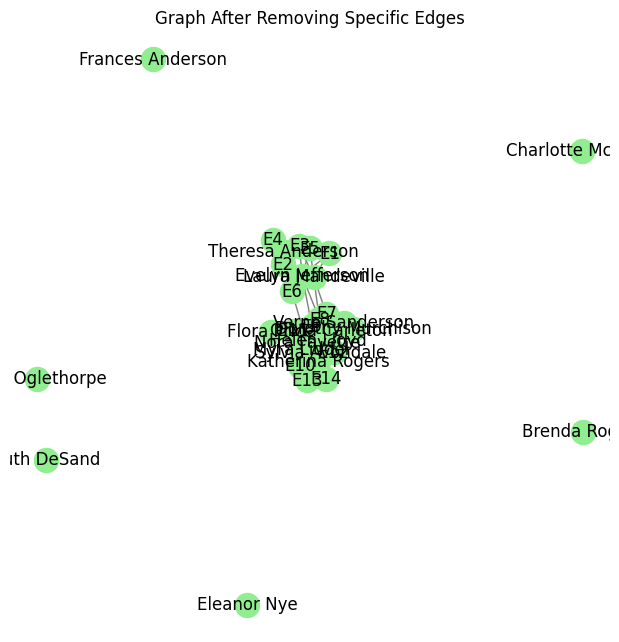

In [ ]:
# Select edges to remove
specific_edges_to_remove =[('Theresa Anderson', 'E7'), ('Theresa Anderson', 'E8'), ('Theresa Anderson', 'E9'), ('Brenda Rogers', 'E1'), ('Brenda Rogers', 'E3'), ('Brenda Rogers', 'E4'), ('Brenda Rogers', 'E5'), ('Brenda Rogers', 'E6'), ('Brenda Rogers', 'E7'), ('Brenda Rogers', 'E8'), ('Charlotte McDowd', 'E3'), ('Charlotte McDowd', 'E4'), ('Charlotte McDowd', 'E5'), ('Charlotte McDowd', 'E7'), ('Frances Anderson', 'E3'), ('Frances Anderson', 'E5'), ('Frances Anderson', 'E6'), ('Eleanor Nye', 'E8'),('Charlotte McDowd', 'E7'), ('Frances Anderson', 'E3'), ('Frances Anderson', 'E5'), ('Frances Anderson', 'E6'), ('Frances Anderson', 'E8'), ('Eleanor Nye', 'E5'), ('Eleanor Nye', 'E6'), ('Eleanor Nye', 'E7'), ('Eleanor Nye', 'E8'), ('Pearl Oglethorpe', 'E6'), ('Pearl Oglethorpe', 'E8'), ('Pearl Oglethorpe', 'E9'), ('Ruth DeSand', 'E5'), ('Ruth DeSand', 'E7'), ('Ruth DeSand', 'E8'), ('Ruth DeSand', 'E9')]
print(f"Edges selected for removal: {specific_edges_to_remove}")

# Print number of edges in original graph
print(f"Number of edges in original graph: {G.number_of_edges()}")

# Remove specific edges for link prediction
def remove_specific_edges(graph, edges_to_remove):
    graph.remove_edges_from(edges_to_remove)
    return graph, edges_to_remove

G, removed_edges = remove_specific_edges(G, specific_edges_to_remove)

# Print number of edges in modified graph
print(f"Number of edges after removal: {G.number_of_edges()}")

# Plot graph after removing edges
plt.figure(figsize=(6, 6))
nx.draw(G, with_labels=True, node_color='lightgreen', edge_color='gray')
plt.title("Graph After Removing Specific Edges")
plt.show()

In [ ]:

# Extract edges and non-edges
edges = list(G.edges())
non_edges = list(combinations(G.nodes(), 2))
non_edges = [pair for pair in non_edges if pair not in edges and pair[::-1] not in edges]

# Split into training and testing sets
train_edges, test_edges = train_test_split(edges, test_size=0.3, random_state=42)
train_graph = nx.Graph()
train_graph.add_nodes_from(G.nodes())  # Preserve all nodes
train_graph.add_edges_from(train_edges)

# Function to compute link prediction scores
def compute_scores(graph, test_set, metric):
    scores = []
    for u, v in test_set:
        if u not in graph or v not in graph:
            scores.append(0)  # Assign a default score if nodes are missing
            continue
        if metric == "adamic_adar":
            score = sum(1 / np.log(graph.degree(w)) for w in nx.common_neighbors(graph, u, v) if graph.degree(w) > 1)
        elif metric == "jaccard":
            score = len(set(nx.common_neighbors(graph, u, v))) / len(set(graph.neighbors(u)) | set(graph.neighbors(v))) if len(set(graph.neighbors(u)) | set(graph.neighbors(v))) > 0 else 0
        elif metric == "preferential_attachment":
            score = graph.degree(u) * graph.degree(v)
        else:
            raise ValueError("Unknown metric")
        scores.append(score)
    return np.array(scores)

# Compute scores
adamic_adar_scores = compute_scores(train_graph, test_edges, "adamic_adar")
jaccard_scores = compute_scores(train_graph, test_edges, "jaccard")
pref_attach_scores = compute_scores(train_graph, test_edges, "preferential_attachment")

# Generate ground truth labels
ground_truth = [1] * len(test_edges) + [0] * len(test_edges)
random_non_edges = np.random.choice(len(non_edges), len(test_edges), replace=False)
test_non_edges = [non_edges[i] for i in random_non_edges]

# Compute scores for non-edges
adamic_adar_scores = np.concatenate([adamic_adar_scores, compute_scores(train_graph, test_non_edges, "adamic_adar")])
jaccard_scores = np.concatenate([jaccard_scores, compute_scores(train_graph, test_non_edges, "jaccard")])
pref_attach_scores = np.concatenate([pref_attach_scores, compute_scores(train_graph, test_non_edges, "preferential_attachment")])


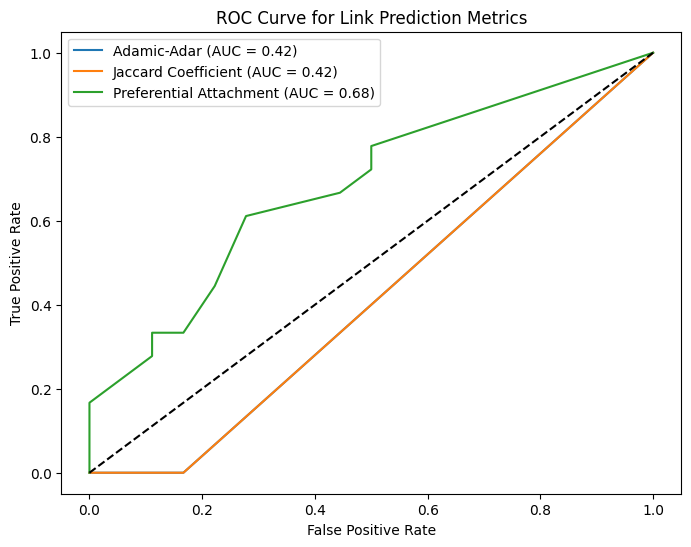

In [ ]:

# Plot ROC Curves
def plot_roc_curve(y_true, y_scores, method):
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{method} (AUC = {roc_auc:.2f})')

plt.figure(figsize=(8, 6))
plot_roc_curve(ground_truth, adamic_adar_scores, "Adamic-Adar")
plot_roc_curve(ground_truth, jaccard_scores, "Jaccard Coefficient")
plot_roc_curve(ground_truth, pref_attach_scores, "Preferential Attachment")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Link Prediction Metrics")
plt.legend()
plt.show()

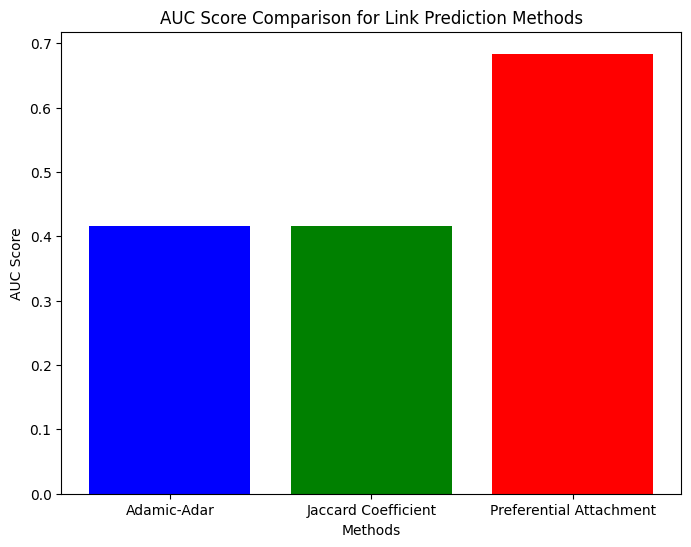

In [ ]:

# Plot bar graphs for comparison
methods = ["Adamic-Adar", "Jaccard Coefficient", "Preferential Attachment"]
auc_scores = [auc(roc_curve(ground_truth, adamic_adar_scores)[0], roc_curve(ground_truth, adamic_adar_scores)[1]),
              auc(roc_curve(ground_truth, jaccard_scores)[0], roc_curve(ground_truth, jaccard_scores)[1]),
              auc(roc_curve(ground_truth, pref_attach_scores)[0], roc_curve(ground_truth, pref_attach_scores)[1])]

plt.figure(figsize=(8, 6))
plt.bar(methods, auc_scores, color=["blue", "green", "red"])
plt.xlabel("Methods")
plt.ylabel("AUC Score")
plt.title("AUC Score Comparison for Link Prediction Methods")
plt.show()